In [294]:
from torch import nn
import torch
from torchsummary import summary
from detection_and_metrics import *
from common import *

import matplotlib.pyplot as plt

In [11]:
%load_ext autoreload
%autoreload 2

### FC classifier model

In [295]:
input_shape = (1, 40, 100)
model = Classifier((40, 100, 1))
model.load_state_dict(torch.load('classifier_model.pth'))

<All keys matched successfully>

In [296]:
summary(model, (1, 40, 100), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 38, 98]             320
       BatchNorm2d-2           [-1, 32, 38, 98]              64
              ReLU-3           [-1, 32, 38, 98]               0
         MaxPool2d-4           [-1, 32, 19, 49]               0
            Conv2d-5           [-1, 64, 17, 47]          18,496
       BatchNorm2d-6           [-1, 64, 17, 47]             128
              ReLU-7           [-1, 64, 17, 47]               0
         MaxPool2d-8            [-1, 64, 8, 23]               0
            Conv2d-9           [-1, 128, 6, 21]          73,856
      BatchNorm2d-10           [-1, 128, 6, 21]             256
             ReLU-11           [-1, 128, 6, 21]               0
          Flatten-12                [-1, 16128]               0
           Linear-13                    [-1, 2]          32,258
          Sigmoid-14                   

### Fully convolutional classifier

In [297]:
detection_model = get_detection_model(model.state_dict())

In [298]:
summary(detection_model, (1, 40, 100), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 38, 98]             320
       BatchNorm2d-2           [-1, 32, 38, 98]              64
              ReLU-3           [-1, 32, 38, 98]               0
         MaxPool2d-4           [-1, 32, 19, 49]               0
            Conv2d-5           [-1, 64, 17, 47]          18,496
       BatchNorm2d-6           [-1, 64, 17, 47]             128
              ReLU-7           [-1, 64, 17, 47]               0
         MaxPool2d-8            [-1, 64, 8, 23]               0
            Conv2d-9           [-1, 128, 6, 21]          73,856
      BatchNorm2d-10           [-1, 128, 6, 21]             256
             ReLU-11           [-1, 128, 6, 21]               0
           Conv2d-12             [-1, 2, 6, 21]          32,258
Total params: 125,378
Trainable params: 125,378
Non-trainable params: 0
-------------------------------

### Detector demonstation

In [274]:
data = read_for_detection('tests/04_unittest_detector_input/test_imgs/', 'tests/04_unittest_detector_input/true_detections.json')

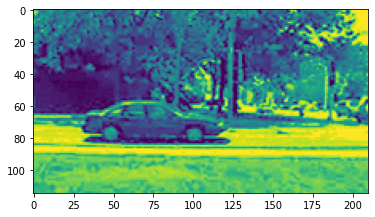

In [284]:
i = 0
img = data[f'test-{i}.png'][0]
bbox = data[f'test-{i}.png'][1:]
plt.imshow(img)

In [285]:
img.shape

(115, 210)

In [286]:
detection_model.eval()
inp = torch.tensor(img).view((1, 1, *img.shape))
heatmap = detection_model(inp).detach().cpu().numpy()

In [287]:
heatmap.shape

(1, 2, 19, 28)

In [288]:
from scipy.signal import correlate2d, gaussian
from cv2 import resize
import cv2

def normalize(img):
    shifted = img - img.min()
    return shifted / shifted.max()

bg_class = normalize(heatmap[0, 0])
car_class = normalize(heatmap[0, 1])

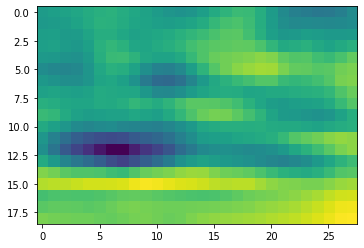

In [289]:
plt.imshow(bg_class)

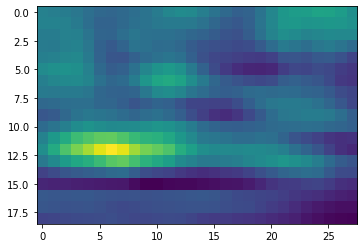

In [290]:
plt.imshow(car_class)

In [293]:
np.unravel_index(np.argmax(car_class), car_class.shape)

(12, 6)

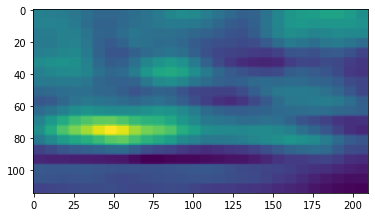

In [291]:
plt.imshow(resize(car_class, img.shape[::-1], interpolation = cv2.INTER_AREA))

In [292]:
car_class_upscaled = resize(car_class, img.shape[::-1], interpolation = cv2.INTER_AREA)
np.unravel_index(np.argmax(car_class_upscaled), car_class_upscaled.shape)

(73, 45)

Thresholding

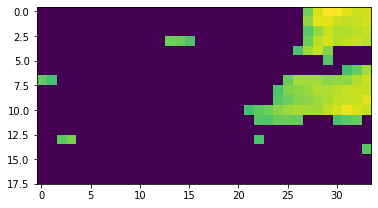

In [216]:
car_thr = car_class.copy()
car_thr[car_thr < 0.7] = 0
plt.imshow(car_thr)

2d cross-correlation with gaussian filter

In [123]:
def gaussian_kernel(kernel_size = (40, 100), std = 3):
    std_x = std
    std_y = std / kernel_size[0] * kernel_size[1]
    g_x = gaussian(kernel_size[0], std = std).reshape(-1)
    g_y = gaussian(kernel_size[1], std = std_y).reshape(-1)
    kernel = np.outer(g_x, g_y)
    return kernel

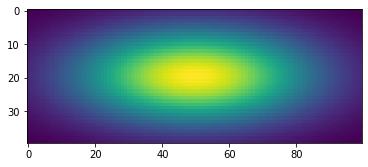

In [124]:
plt.imshow(gaussian_kernel((40, 100), 10))

In [125]:
kernel = gaussian_kernel((40, 100), 10)
corr = correlate2d(car_thr, kernel, mode = 'same')

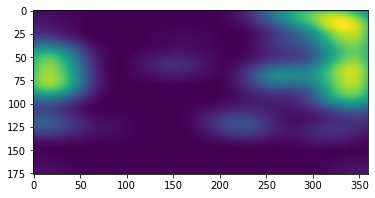

In [126]:
plt.imshow(corr)

In [127]:
CAR_SIZE = (40, 100)
max_idx = np.unravel_index(np.argmax(corr), corr.shape)
bbox = corr[max(0, max_idx[0] - CAR_SIZE[0] // 2):min(max_idx[0] + CAR_SIZE[0] // 2, corr.shape[0]), max(0, max_idx[1] - CAR_SIZE[1] // 2):min(max_idx[1] + CAR_SIZE[1] // 2, corr.shape[1])].copy()
bbox_norm = normalize(bbox)
conf = normalize(bbox_norm).sum() / kernel.sum()
conf, max_idx

(1.2125803930877803, (14, 331))

In [128]:
CAR_SIZE = (40, 100)
corr[max_idx[0] - 20:max_idx[0] + 20, max_idx[1] - 50:max_idx[1] + 50] = 0
corr[max(0, max_idx[0] - CAR_SIZE[0] // 2):min(max_idx[0] + CAR_SIZE[0] // 2, corr.shape[0]), max(0, max_idx[1] - CAR_SIZE[1] // 2):min(max_idx[1] + CAR_SIZE[1] // 2, corr.shape[1])] = 0

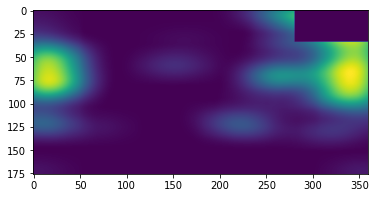

In [129]:
plt.imshow(corr)

### Bounding box search

In [115]:
test_data ={}
for fname, d in list(data.items()):
    test_data[fname] = d[0]
detections = get_detections(detection_model, test_data)

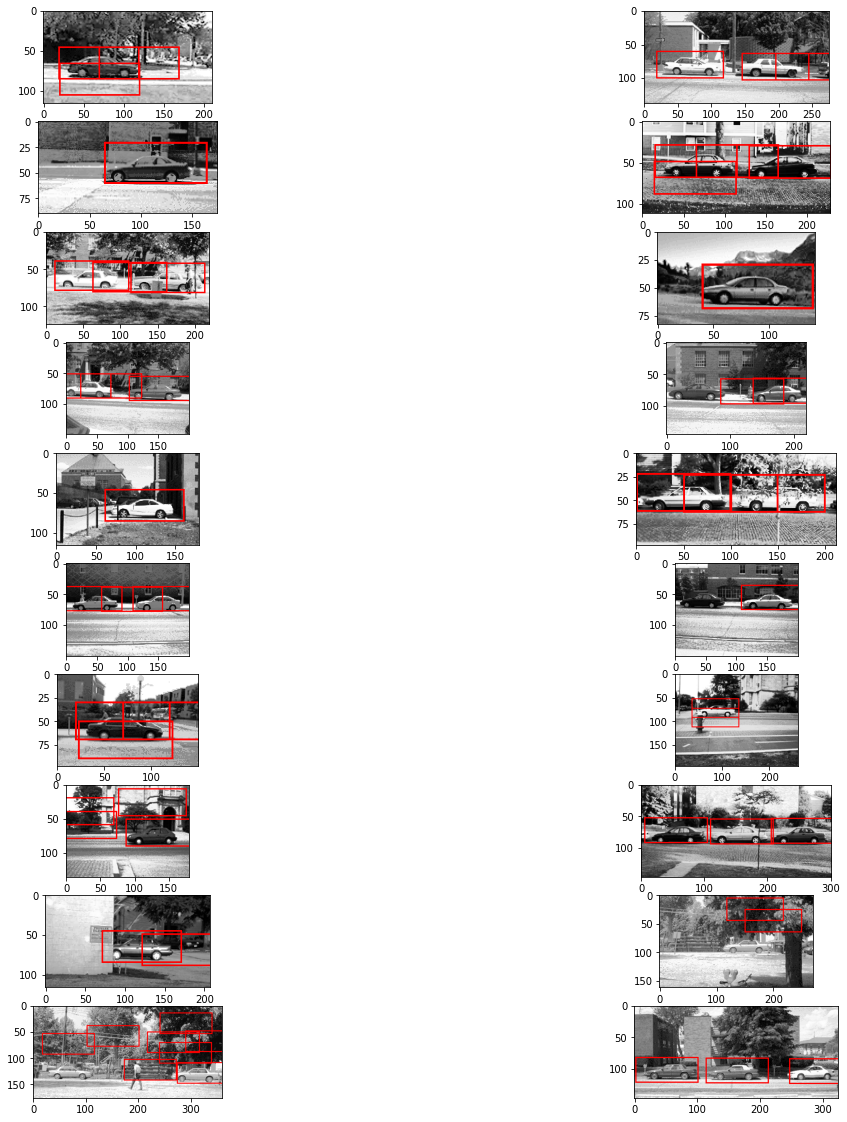

In [116]:
from PIL import Image, ImageDraw

i = 1
n = 20

fig, ax = plt.subplots(n // 2, 2)

for i in range(n):
    uint_image = data[f'test-{i}.png'][0] * 255 // np.max(data[f'test-{i}.png'][0])
    uint_image = uint_image.astype(np.uint8)
    img = Image.fromarray(np.dstack([uint_image, uint_image, uint_image]))

    draw = ImageDraw.Draw(img)
    for bbox in detections[f'test-{i}.png']:
        draw.rectangle((bbox[1], bbox[0], bbox[1] + bbox[3], bbox[0] + bbox[2]), fill = None, outline = (255, 0, 0), width = 2)
    im = np.asarray(img, dtype = np.uint8)
    ax[i // 2, i % 2].imshow(im)
    
fig.set_size_inches(20, 20)

### AUC